In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_14/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_14.csv').dropna()
print(training_data_df.shape)
training_data_df.head()

(2619263, 521)
Wall time: 1min 40s


,전용면적,금액(만원),층,가격면적,target_log_transformed,targetarea_log_transformed,주택가격지수,전용면적_mean,전용면적_min,전용면적_max,건물나이,year_linear,month_sin,month_cos,xnorm,ynorm,x_2nd,y_2nd,x_sin,y_sin,x_cos,y_cos,xy,trade_type,공시지가(만원),표준지여부,enviro_mean,enviro_max,enviro_min,epi_mean,epi_max,epi_min,주_용도_부대시설_있음,주_용도_주차장_있음,주_용도_복리시설_있음,주_용도_사무소_있음,주_용도_소매점_있음,주_용도_차고_있음,주_용도_일반음식점_있음,주_용도_기타제1종근생활시설_있음,주_용도_기타제2종근생활시설_있음,주_용도_기타근린생활시설_있음,주_용도_기타창고시설_있음,주_용도_기타판매시설_있음,주_용도_기타일반업무시설_있음,주_용도_기타사무소_있음,주_용도_유치원_있음,주_용도_노인복지시설_있음,주_용도_치과의원_있음,주_용도_의원_있음,주_용도_제조업소_있음,주_용도_대피소_있음,주_용도_휴게음식점_있음,주_용도_학원_있음,주_용도_생활편익시설_있음,주_용도_세탁소_있음,주_용도_창고_있음,주_용도_독서실_있음,주_용도_기타노유자시설_있음,주_용도_부동산중개업소_있음,주_용도_기원_있음,주_용도_기타교육연구시설_있음,주_용도_이(미)용원_있음,주_용도_멀티미디어문화컨텐츠설비제공업소_있음,주_용도_기타자동차관련시설_있음,주_용도_어린이집_있음,주_용도_한의원_있음,주_용도_금융업소_있음,주_용도_파출소_있음,주_용도_인터넷컴퓨터게임시설제공업소_있음,주_용도_상점_있음,주_용도_게임제공업소_있음,주_용도_기타교육연구및복지시설_있음,주_용도_출판사_있음,주_용도_일반목욕장_있음,주_용도_공중화장실_있음,주_용도_부동산중개사무소_있음,주_용도_미용원_있음,주_용도_기타아동관련시설_있음,주_용도_기타공장_있음,주_용도_수리점_있음,주_용도_영유아보육시설_있음,주_용도_연구소_있음,주_용도_체육도장_있음,주_용도_지역아동센터_있음,주_용도_체육장_있음,주_용도_기타종교집회장_있음,주_용도_기타_운동시설_있음,주_용도_노래연습장_있음,주_용도_당구장_있음,주_용도_기타의료시설_있음,주_용도_아동복지시설_있음,주_용도_의약품도매점_있음,주_용도_교회_있음,주_용도_단란주점_있음,주_용도_조산원_있음,주_용도_침술원_있음,주_용도_표구점_있음,주_용도_목욕장_있음,주_용도_기타운동시설_있음,주_용도_기타문화및집회시설_있음,주_용도_기타전시장_있음,주_용도_사진관_있음,주_용도_체력단련장_있음,주_용도_조산소_있음,주_용도_접골원_있음,주_용도_기타공연장_있음,주_용도_탁구장_있음,주_용도_시장_있음,주_용도_직업훈련소_있음,주_용도_기타집회장_있음,주_용도_골프연습장_있음,주_용도_교육(연수)원_있음,주_용도_결혼상담소_있음,주_용도_인터넷컴퓨터게임시설제공업의시설_있음,주_용도_기타종교시설_있음,주_용도_사회복지시설_있음,주_용도_기타공공시설_있음,주_용도_기타판매및영업시설_있음,주_용도_사찰_있음,주_용도_의약품판매소_있음,주_용도_의료기기판매소_있음,주_용도_청소년게임제공업의시설_있음,주_용도_이용원_있음,주_용도_서점(1종근.생미해당)_있음,주_용도_기타위락시설_있음,주_용도_마을공동시설_있음,주_용도_기타위험물저장처리시설_있음,주_용도_변전소_있음,주_용도_병원_있음,주_용도_동물병원_있음,주_용도_유흥주점_있음,주_용도_예식장_있음,주_용도_수퍼마켓_있음,주_용도_공공도서관_있음,주_용도_자동차영업소_있음,주_용도_분뇨처리시설_있음,주_용도_기타소매시장_있음,주_용도_온실_있음,주_용도_소매시장_있음,주_용도_야외극장_있음,주_용도_창고시설_있음,주_용도_에어로빅장_있음,주_용도_제2종근린생활시설_있음,주_용도_한방병원_있음,주_용도_기타병원_있음,주_용도_제과점_있음,주_용도_기타분뇨쓰레기처리시설_있음,주_용도_일반공장_있음,주_용도_기타공공업무시설_있음,주_용도_정수장_있음,주_용도_일반창고_있음,주_용도_운동장시설_있음,주_용도_여관_있음,주_용도_고시원_있음,주_용도_치과병원_있음,주_용도_관광호텔_있음,주_용도_도서관_있음,주_용도_비디오물감상실_있음,주_용도_볼링장_있음,주_용도_교육원_있음,주_용도_마을공동작업소_있음,주_용도_산부인과병원_있음,주_용도_소개업_있음,주_용도_수족관_있음,주_용도_동사무소_있음,주_용도_운동시설_있음,주_용도_기숙사_있음,주_용도_체육관_있음,주_용도_총포판매소_있음,주_용도_미술관_있음,주_용도_백화점_있음,주_용도_기타학교_있음,주_용도_공관_있음,주_용도_기타제2종근린생활시설_있음,주_용도_기타제1종근린생활시설_있음,주_용도_고압가스충전저장소_있음,주_용도_초등학교_있음,주_용도_세차장_있음,주_용도_성당_있음,주_용도_축사_있음,주_용도_기타관광휴게시설_있음,주_용도_보건소_있음,주_용도_고등학교_있음,주_용도_산후조리원_있음,주_용도_교습소_있음,주_용도_청소년게임제공업소_있음,주_용도_야외음악당_있음,주_용도_수도원_있음,주_용도_제실_있음,주_용도_자치단체청사_있음,주_용도_국방_군사시설_있음,주_용도_지구대_있음,주_용도_동물미용실_있음,주_용도_도료류판매소_있음,층min,층max,층mean,층median,구조_철근콘크리트구조_fraction,구조_내력벽식_fraction,구조_연와조_fraction,구조_조적조_fraction,구조_일반철골조_fraction,구조_세멘벽돌조_fraction,구조_기둥식_fraction,구조_경량철골조_fraction,구조_벽돌조_fraction,구조_기타구조_fraction,구조_판넬조_fraction,구조_프리캐스트_fraction,구조_기타블럭조_fraction,구조_세멘블럭조_fraction,구조_옹벽식_fraction,구조_목조_fraction,구조_조립식_fraction,구조_무량판구조_fraction,구조_석구조_fraction,구조_흙구조_fraction,지붕_평지붕_fraction,지붕_철콘지붕_fraction,지붕_경사지붕_fraction,지붕_기타지붕_fraction,지붕_기와지붕_fraction,지붕_판넬지붕_fraction,지붕_박공지붕_fraction,지붕_모임지붕_fraction,지붕_스페니쉬기와_fraction,지붕_슬레이트지붕_fraction,지붕_초가지붕_fraction,지붕_멘사드지붕_fraction,지붕_철골지붕_fraction,지붕_함석지붕_fraction,지붕_목구조지붕_fraction,지붕_원형지붕_fraction,지붕_금속지붕_fraction,지붕_전통지붕_fraction,지붕_비닐지붕_fraction,최고층-층norm,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,연면적,토지면적대연면적비,토지연면적비곱공시지가,...,공공도서관,공공문화체육시설미분류,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M~70M),광로3류(폭_40M~50M),광역계획구역,광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용용도지구기타,근린공원,근린광장,근린상업지역,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타보건위생시설,기타수도시설,기타용도지역지구기타,기타용지,기타유통업무설비,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도54-236m),대공방어협조구역(위탁고도77-257m),대로1류(폭_35M~40M),대로2류(폭_30M~35M),대로3류(폭_25M~30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구

In [3]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

,colname
0,trade_type
1,표준지여부
2,건물나이
3,지목명
4,용도지역명1


In [4]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [5]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

278

In [6]:
cat_cols

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면',
 '(한강)오염행위_제한지역',
 '(한강)폐기물매립시설_설치제한지역',
 '4대문안',
 '가로구역별_최고높이_제한지역',
 '가스공급설비',
 '가축사육제한구역',
 '개발제한구역',
 '개발진흥지구',
 '개발행위허가제한지역',
 '건축선',
 '건축용도지역기타',
 '건축용도지역미분류',
 '경관광장',
 '경관녹지',
 '경관지구',
 '경관지구기타',
 '고도지구',
 '고등학교',
 '고속철도',
 '공공공지',
 '공공도서관',
 '공공문화체육시설미분류',
 '공공시설구역',
 '공공주택지구',
 '공공지원민간임대주택_공급촉진지구',
 '공공청사',
 '공동구',
 '공용시설보호지구',
 '공원',
 '공원마을지구(공원집단시설지구)',
 '공원자연보존지구',
 '공원자연환경지구',
 '공익용산지',
 '공익임지',
 '공장설립승인지역',
 '공장설립제한지역',
 '공항소음피해예상지역',
 '공항시설보호지구',
 '과밀억제권역',
 '광로1류(폭_70M_이상)',
 '광로2류(폭_50M~70M)',
 '광로3류(폭_40M~50M)',
 '광역계획구역',
 '광장',
 '교육환경보호구역',
 '교통광장',
 '국가산업단지',
 '국가지정문화재구역',
 '국가하천',
 '국립공원',
 '국민임대주택단지예정지구',
 '국지도로',
 '국토이용용도지구기타',
 '근린공원',
 '근린광장',
 '근린상업지역',
 '기타공공청사시설',
 '기타공원시설',
 '기타교통시설',
 '기타녹지시설',
 '기타도로시설',
 '기타도시공간시설',
 '기타문화시설',
 '기타보건위생시설',
 '기타수도시설',
 '기타용도지역지구기타',
 '기타용지',
 '기타유통업무설비',
 '기타자동차정류장',
 '기타주차장시설',
 '기타철도시설',
 '기타폐기물처리시설',
 '노외주차장',
 '녹지',

In [7]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(523853, 521)
(419082, 521)
(1676328, 521)


In [8]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed']#, 'land_area_log']

In [9]:
x_test = test_data.drop(columns=target_cols)
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

(523853, 517)
(523853,)


In [10]:
x_valid = valid_data.drop(columns=target_cols)
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

(419082, 517)
(419082,)


In [11]:
x_train = train_data.drop(columns=target_cols)
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

(1676328, 517)
(1676328,)


<AxesSubplot:>

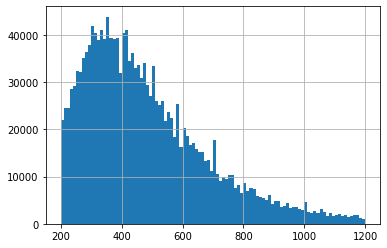

In [12]:
y_train.hist(bins=100)

# Training

In [13]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [14]:
import lightgbm as lgb

In [15]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse'
}

In [16]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [17]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=200, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.534859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8339
[LightGBM] [Info] Number of data points in the train set: 1676328, number of used features: 476


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 481.769315
Training until validation scores don't improve for 200 rounds
[50]	valid_0's rmse: 115.734
[100]	valid_0's rmse: 97.4911
[150]	valid_0's rmse: 89.2334
[200]	valid_0's rmse: 84.6076
[250]	valid_0's rmse: 81.4958
[300]	valid_0's rmse: 79.204
[350]	valid_0's rmse: 77.3251
[400]	valid_0's rmse: 75.819
[450]	valid_0's rmse: 74.5905
[500]	valid_0's rmse: 73.5253
[550]	valid_0's rmse: 72.6177
[600]	valid_0's rmse: 71.8062
[650]	valid_0's rmse: 71.1151
[700]	valid_0's rmse: 70.4775
[750]	valid_0's rmse: 69.9018
[800]	valid_0's rmse: 69.387
[850]	valid_0's rmse: 68.8813
[900]	valid_0's rmse: 68.3987
[950]	valid_0's rmse: 67.9592
[1000]	valid_0's rmse: 67.5293
[1050]	valid_0's rmse: 67.1405
[1100]	valid_0's rmse: 66.7702
[1150]	valid_0's rmse: 66.4282
[1200]	valid_0's rmse: 66.0968
[1250]	valid_0's rmse: 65.7833
[1300]	valid_0's rmse: 65.4884
[1350]	valid_0's rmse: 65.2181
[1400]	valid_0's rmse: 64.9565
[1450]	valid_0's rmse: 64.7046
[1500]	

[13100]	valid_0's rmse: 51.6401
[13150]	valid_0's rmse: 51.6243
[13200]	valid_0's rmse: 51.6064
[13250]	valid_0's rmse: 51.5908
[13300]	valid_0's rmse: 51.5766
[13350]	valid_0's rmse: 51.5603
[13400]	valid_0's rmse: 51.5464
[13450]	valid_0's rmse: 51.5315
[13500]	valid_0's rmse: 51.5181
[13550]	valid_0's rmse: 51.5013
[13600]	valid_0's rmse: 51.4852
[13650]	valid_0's rmse: 51.4699
[13700]	valid_0's rmse: 51.4551
[13750]	valid_0's rmse: 51.4392
[13800]	valid_0's rmse: 51.4251
[13850]	valid_0's rmse: 51.4127
[13900]	valid_0's rmse: 51.3996
[13950]	valid_0's rmse: 51.3858
[14000]	valid_0's rmse: 51.3702
[14050]	valid_0's rmse: 51.3525
[14100]	valid_0's rmse: 51.3392
[14150]	valid_0's rmse: 51.3249
[14200]	valid_0's rmse: 51.3112
[14250]	valid_0's rmse: 51.2963
[14300]	valid_0's rmse: 51.2816
[14350]	valid_0's rmse: 51.2683
[14400]	valid_0's rmse: 51.2546
[14450]	valid_0's rmse: 51.2401
[14500]	valid_0's rmse: 51.2237
[14550]	valid_0's rmse: 51.2074
[14600]	valid_0's rmse: 51.1931
[14650]	

[25950]	valid_0's rmse: 48.9839
[26000]	valid_0's rmse: 48.9777
[26050]	valid_0's rmse: 48.9726
[26100]	valid_0's rmse: 48.9659
[26150]	valid_0's rmse: 48.9592
[26200]	valid_0's rmse: 48.9521
[26250]	valid_0's rmse: 48.9461
[26300]	valid_0's rmse: 48.9399
[26350]	valid_0's rmse: 48.933
[26400]	valid_0's rmse: 48.9262
[26450]	valid_0's rmse: 48.9196
[26500]	valid_0's rmse: 48.9121
[26550]	valid_0's rmse: 48.9056
[26600]	valid_0's rmse: 48.8997
[26650]	valid_0's rmse: 48.8931
[26700]	valid_0's rmse: 48.8869
[26750]	valid_0's rmse: 48.8794
[26800]	valid_0's rmse: 48.8733
[26850]	valid_0's rmse: 48.8668
[26900]	valid_0's rmse: 48.8612
[26950]	valid_0's rmse: 48.8538
[27000]	valid_0's rmse: 48.848
[27050]	valid_0's rmse: 48.8429
[27100]	valid_0's rmse: 48.8352
[27150]	valid_0's rmse: 48.8296
[27200]	valid_0's rmse: 48.8245
[27250]	valid_0's rmse: 48.8197
[27300]	valid_0's rmse: 48.8143
[27350]	valid_0's rmse: 48.8089
[27400]	valid_0's rmse: 48.8037
[27450]	valid_0's rmse: 48.7975
[27500]	va

[38800]	valid_0's rmse: 47.7521
[38850]	valid_0's rmse: 47.7488
[38900]	valid_0's rmse: 47.746
[38950]	valid_0's rmse: 47.7431
[39000]	valid_0's rmse: 47.7404
[39050]	valid_0's rmse: 47.7353
[39100]	valid_0's rmse: 47.7313
[39150]	valid_0's rmse: 47.7282
[39200]	valid_0's rmse: 47.7249
[39250]	valid_0's rmse: 47.7218
[39300]	valid_0's rmse: 47.7193
[39350]	valid_0's rmse: 47.7173
[39400]	valid_0's rmse: 47.7135
[39450]	valid_0's rmse: 47.7106
[39500]	valid_0's rmse: 47.7075
[39550]	valid_0's rmse: 47.7034
[39600]	valid_0's rmse: 47.6995
[39650]	valid_0's rmse: 47.6968
[39700]	valid_0's rmse: 47.6935
[39750]	valid_0's rmse: 47.6902
[39800]	valid_0's rmse: 47.6862
[39850]	valid_0's rmse: 47.6811
[39900]	valid_0's rmse: 47.6773
[39950]	valid_0's rmse: 47.6741
[40000]	valid_0's rmse: 47.6709
[40050]	valid_0's rmse: 47.6673
[40100]	valid_0's rmse: 47.6641
[40150]	valid_0's rmse: 47.6609
[40200]	valid_0's rmse: 47.6574
[40250]	valid_0's rmse: 47.6546
[40300]	valid_0's rmse: 47.6505
[40350]	v

[51650]	valid_0's rmse: 47.0483
[51700]	valid_0's rmse: 47.0461
[51750]	valid_0's rmse: 47.0438
[51800]	valid_0's rmse: 47.0413
[51850]	valid_0's rmse: 47.0395
[51900]	valid_0's rmse: 47.0367
[51950]	valid_0's rmse: 47.0349
[52000]	valid_0's rmse: 47.0322
[52050]	valid_0's rmse: 47.0299
[52100]	valid_0's rmse: 47.0272
[52150]	valid_0's rmse: 47.0252
[52200]	valid_0's rmse: 47.0224
[52250]	valid_0's rmse: 47.0201
[52300]	valid_0's rmse: 47.0188
[52350]	valid_0's rmse: 47.0169
[52400]	valid_0's rmse: 47.0143
[52450]	valid_0's rmse: 47.0129
[52500]	valid_0's rmse: 47.0105
[52550]	valid_0's rmse: 47.0085
[52600]	valid_0's rmse: 47.0068
[52650]	valid_0's rmse: 47.004
[52700]	valid_0's rmse: 47.0009
[52750]	valid_0's rmse: 46.9986
[52800]	valid_0's rmse: 46.9967
[52850]	valid_0's rmse: 46.9947
[52900]	valid_0's rmse: 46.9919
[52950]	valid_0's rmse: 46.9896
[53000]	valid_0's rmse: 46.9878
[53050]	valid_0's rmse: 46.9857
[53100]	valid_0's rmse: 46.9825
[53150]	valid_0's rmse: 46.9814
[53200]	v

[64500]	valid_0's rmse: 46.5847
[64550]	valid_0's rmse: 46.5828
[64600]	valid_0's rmse: 46.5815
[64650]	valid_0's rmse: 46.5803
[64700]	valid_0's rmse: 46.5779
[64750]	valid_0's rmse: 46.5763
[64800]	valid_0's rmse: 46.575
[64850]	valid_0's rmse: 46.5734
[64900]	valid_0's rmse: 46.572
[64950]	valid_0's rmse: 46.5709
[65000]	valid_0's rmse: 46.5691
[65050]	valid_0's rmse: 46.5679
[65100]	valid_0's rmse: 46.5661
[65150]	valid_0's rmse: 46.5647
[65200]	valid_0's rmse: 46.5634
[65250]	valid_0's rmse: 46.5623
[65300]	valid_0's rmse: 46.5612
[65350]	valid_0's rmse: 46.5599
[65400]	valid_0's rmse: 46.5583
[65450]	valid_0's rmse: 46.5564
[65500]	valid_0's rmse: 46.5549
[65550]	valid_0's rmse: 46.5532
[65600]	valid_0's rmse: 46.5516
[65650]	valid_0's rmse: 46.5501
[65700]	valid_0's rmse: 46.5488
[65750]	valid_0's rmse: 46.5468
[65800]	valid_0's rmse: 46.5453
[65850]	valid_0's rmse: 46.5435
[65900]	valid_0's rmse: 46.5419
[65950]	valid_0's rmse: 46.5403
[66000]	valid_0's rmse: 46.538
[66050]	val

[77350]	valid_0's rmse: 46.2423
[77400]	valid_0's rmse: 46.241
[77450]	valid_0's rmse: 46.2398
[77500]	valid_0's rmse: 46.2383
[77550]	valid_0's rmse: 46.2375
[77600]	valid_0's rmse: 46.2366
[77650]	valid_0's rmse: 46.2358
[77700]	valid_0's rmse: 46.235
[77750]	valid_0's rmse: 46.2343
[77800]	valid_0's rmse: 46.2332
[77850]	valid_0's rmse: 46.2323
[77900]	valid_0's rmse: 46.231
[77950]	valid_0's rmse: 46.2298
[78000]	valid_0's rmse: 46.2294
[78050]	valid_0's rmse: 46.2283
[78100]	valid_0's rmse: 46.2271
[78150]	valid_0's rmse: 46.2266
[78200]	valid_0's rmse: 46.225
[78250]	valid_0's rmse: 46.2234
[78300]	valid_0's rmse: 46.2224
[78350]	valid_0's rmse: 46.2212
[78400]	valid_0's rmse: 46.2199
[78450]	valid_0's rmse: 46.2187
[78500]	valid_0's rmse: 46.2173
[78550]	valid_0's rmse: 46.2162
[78600]	valid_0's rmse: 46.2147
[78650]	valid_0's rmse: 46.2138
[78700]	valid_0's rmse: 46.2122
[78750]	valid_0's rmse: 46.2111
[78800]	valid_0's rmse: 46.2099
[78850]	valid_0's rmse: 46.2086
[78900]	vali

[90200]	valid_0's rmse: 46.0071
[90250]	valid_0's rmse: 46.0063
[90300]	valid_0's rmse: 46.0046
[90350]	valid_0's rmse: 46.0038
[90400]	valid_0's rmse: 46.0032
[90450]	valid_0's rmse: 46.0025
[90500]	valid_0's rmse: 46.0016
[90550]	valid_0's rmse: 46.0012
[90600]	valid_0's rmse: 46.0004
[90650]	valid_0's rmse: 45.9997
[90700]	valid_0's rmse: 45.9993
[90750]	valid_0's rmse: 45.999
[90800]	valid_0's rmse: 45.9979
[90850]	valid_0's rmse: 45.9973
[90900]	valid_0's rmse: 45.997
[90950]	valid_0's rmse: 45.9961
[91000]	valid_0's rmse: 45.9955
[91050]	valid_0's rmse: 45.9944
[91100]	valid_0's rmse: 45.9939
[91150]	valid_0's rmse: 45.9937
[91200]	valid_0's rmse: 45.9935
[91250]	valid_0's rmse: 45.9933
[91300]	valid_0's rmse: 45.9927
[91350]	valid_0's rmse: 45.9912
[91400]	valid_0's rmse: 45.9899
[91450]	valid_0's rmse: 45.9889
[91500]	valid_0's rmse: 45.9879
[91550]	valid_0's rmse: 45.9874
[91600]	valid_0's rmse: 45.9866
[91650]	valid_0's rmse: 45.9857
[91700]	valid_0's rmse: 45.985
[91750]	val

[102950]	valid_0's rmse: 45.8372
[103000]	valid_0's rmse: 45.8368
[103050]	valid_0's rmse: 45.8361
[103100]	valid_0's rmse: 45.8356
[103150]	valid_0's rmse: 45.8349
[103200]	valid_0's rmse: 45.8341
[103250]	valid_0's rmse: 45.8332
[103300]	valid_0's rmse: 45.8324
[103350]	valid_0's rmse: 45.8318
[103400]	valid_0's rmse: 45.8312
[103450]	valid_0's rmse: 45.8309
[103500]	valid_0's rmse: 45.8303
[103550]	valid_0's rmse: 45.8298
[103600]	valid_0's rmse: 45.8291
[103650]	valid_0's rmse: 45.8284
[103700]	valid_0's rmse: 45.8282
[103750]	valid_0's rmse: 45.8278
[103800]	valid_0's rmse: 45.8274
[103850]	valid_0's rmse: 45.8267
[103900]	valid_0's rmse: 45.8263
[103950]	valid_0's rmse: 45.8257
[104000]	valid_0's rmse: 45.8251
[104050]	valid_0's rmse: 45.8248
[104100]	valid_0's rmse: 45.8239
[104150]	valid_0's rmse: 45.8229
[104200]	valid_0's rmse: 45.8227
[104250]	valid_0's rmse: 45.8221
[104300]	valid_0's rmse: 45.8211
[104350]	valid_0's rmse: 45.8205
[104400]	valid_0's rmse: 45.8199
[104450]	v

[115400]	valid_0's rmse: 45.7195
[115450]	valid_0's rmse: 45.7193
[115500]	valid_0's rmse: 45.7188
[115550]	valid_0's rmse: 45.7185
[115600]	valid_0's rmse: 45.7183
[115650]	valid_0's rmse: 45.7178
[115700]	valid_0's rmse: 45.7173
[115750]	valid_0's rmse: 45.7168
[115800]	valid_0's rmse: 45.7162
[115850]	valid_0's rmse: 45.7161
[115900]	valid_0's rmse: 45.7157
[115950]	valid_0's rmse: 45.7155
[116000]	valid_0's rmse: 45.7148
[116050]	valid_0's rmse: 45.7142
[116100]	valid_0's rmse: 45.7139
[116150]	valid_0's rmse: 45.7133
[116200]	valid_0's rmse: 45.7131
[116250]	valid_0's rmse: 45.7125
[116300]	valid_0's rmse: 45.7121
[116350]	valid_0's rmse: 45.7119
[116400]	valid_0's rmse: 45.7117
[116450]	valid_0's rmse: 45.7114
[116500]	valid_0's rmse: 45.7111
[116550]	valid_0's rmse: 45.711
[116600]	valid_0's rmse: 45.7104
[116650]	valid_0's rmse: 45.7104
[116700]	valid_0's rmse: 45.7098
[116750]	valid_0's rmse: 45.7097
[116800]	valid_0's rmse: 45.7091
[116850]	valid_0's rmse: 45.7087
[116900]	va

[127850]	valid_0's rmse: 45.631
[127900]	valid_0's rmse: 45.631
[127950]	valid_0's rmse: 45.6305
[128000]	valid_0's rmse: 45.6301
[128050]	valid_0's rmse: 45.6298
[128100]	valid_0's rmse: 45.6293
[128150]	valid_0's rmse: 45.6289
[128200]	valid_0's rmse: 45.6286
[128250]	valid_0's rmse: 45.6283
[128300]	valid_0's rmse: 45.628
[128350]	valid_0's rmse: 45.6277
[128400]	valid_0's rmse: 45.6275
[128450]	valid_0's rmse: 45.6272
[128500]	valid_0's rmse: 45.627
[128550]	valid_0's rmse: 45.6265
[128600]	valid_0's rmse: 45.6261
[128650]	valid_0's rmse: 45.6257
[128700]	valid_0's rmse: 45.6256
[128750]	valid_0's rmse: 45.6252
[128800]	valid_0's rmse: 45.6248
[128850]	valid_0's rmse: 45.6246
[128900]	valid_0's rmse: 45.6245
[128950]	valid_0's rmse: 45.6242
[129000]	valid_0's rmse: 45.6239
[129050]	valid_0's rmse: 45.6238
[129100]	valid_0's rmse: 45.6235
[129150]	valid_0's rmse: 45.6229
[129200]	valid_0's rmse: 45.6227
[129250]	valid_0's rmse: 45.6223
[129300]	valid_0's rmse: 45.6221
[129350]	valid

[140350]	valid_0's rmse: 45.5628
[140400]	valid_0's rmse: 45.5628
[140450]	valid_0's rmse: 45.5626
[140500]	valid_0's rmse: 45.5624
[140550]	valid_0's rmse: 45.5621
[140600]	valid_0's rmse: 45.5621
[140650]	valid_0's rmse: 45.5618
[140700]	valid_0's rmse: 45.5617
[140750]	valid_0's rmse: 45.5615
[140800]	valid_0's rmse: 45.5613
[140850]	valid_0's rmse: 45.5612
[140900]	valid_0's rmse: 45.561
[140950]	valid_0's rmse: 45.5607
[141000]	valid_0's rmse: 45.5605
[141050]	valid_0's rmse: 45.5603
[141100]	valid_0's rmse: 45.5603
[141150]	valid_0's rmse: 45.5601
[141200]	valid_0's rmse: 45.5597
[141250]	valid_0's rmse: 45.5594
[141300]	valid_0's rmse: 45.5592
[141350]	valid_0's rmse: 45.5592
[141400]	valid_0's rmse: 45.559
[141450]	valid_0's rmse: 45.5587
[141500]	valid_0's rmse: 45.5584
[141550]	valid_0's rmse: 45.5582
[141600]	valid_0's rmse: 45.5577
[141650]	valid_0's rmse: 45.5573
[141700]	valid_0's rmse: 45.5574
[141750]	valid_0's rmse: 45.5571
[141800]	valid_0's rmse: 45.557
[141850]	vali

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(bst)

In [ ]:
sample_df = x_valid.sample(n=1000)

In [ ]:
shap_values = explainer.shap_values(sample_df)

In [ ]:
shap_values_df = pd.DataFrame(shap_values)

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df.columns = x_valid.columns

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values(0, ascending=False)

In [ ]:
shap_summary_df.head(50)

In [ ]:
under_zero_df = over_zero_df = shap_summary_df[shap_summary_df[0] <= 0]
under_zero_df.shape

In [ ]:
under_zero_df

In [ ]:
over_zero_df = shap_summary_df[shap_summary_df[0] > 0]
over_zero_df.shape

In [ ]:
over_zero_df = over_zero_df.transpose()
over_zero_df.head()

In [ ]:
over_zero_df.to_csv(basedir + 'over_zero_shap_score_features.csv', index=False)

In [ ]:
selected_features = over_zero_df.columns.tolist()

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
import lightgbm as lgb

In [ ]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'seed': 42,
    'max_depth': -1,
    'num_leaves':31,
    'lambda_l2':0,
    'metric':'rmse',
    'tree_learner':'feature'
}

In [ ]:
cat_cols = [col for col in cat_cols if col in selected_features]
len(cat_cols)

In [ ]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [ ]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=5000, verbose_eval=50)

In [ ]:
lgb.plot_importance(bst)

In [ ]:
preds = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
bst.save_model('lgb_model_for_training_data_ver_8.txt')

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_training_data_ver_8.csv', index=False)

In [ ]:
pd.DataFrame({'preds':preds}).to_csv('lgb_preds_training_data_ver_8.csv', index=False)

In [ ]:
y_test_pricearea = test_data['가격/면적']

In [ ]:
r2_score(y_test, preds)

In [ ]:
r2_score(y_test_pricearea, np.e**preds)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, preds)

In [ ]:
mean_squared_error(y_test_pricearea, np.e**preds)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'preds':preds})
print(compare_df.shape)
compare_df.head(50)

In [ ]:
compare_df.tail()

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.01)#, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)

In [ ]:
%%time
shap_values = model.get_feature_importance(data=val_pool, type='ShapValues')

In [ ]:
shap_values.shape

In [ ]:
val_pool.shape

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(model)

In [ ]:
colnames_map_df = pd.DataFrame({'colnames':x_valid.columns,'map':[i for i in range(len(x_valid.columns))]})
colnames_map_df.head()

In [ ]:
x_valid.columns = colnames_map_df['map'].tolist()
x_valid.head()

In [ ]:
summary = shap.summary_plot(shap_values[:,:-1], x_valid, max_display=x_valid.shape[1])

In [ ]:
shap_values_df = pd.DataFrame(shap_values[:,:-1])
shap_values_df.head()

In [ ]:
shap_summary_df = pd.DataFrame()

In [ ]:
np.mean(np.abs(shap_values_df[0].values))

In [ ]:
for col in shap_values_df.columns:
    shap_summary_df[col] = [np.mean(np.abs(shap_values_df[col].values))]

In [ ]:
shap_summary_df

In [ ]:
shap_summary_df = shap_summary_df.transpose().sort_values([0], ascending=False)

In [ ]:
shap_summary_df.head()

In [ ]:
selected_features_map = shap_summary_df.index[:330].values

In [ ]:
selected_features_list = []
for v in selected_features_map:
    selected_features_list.append(colnames_map_df.iloc[v,0])

In [ ]:
selected_features_list

In [ ]:
selected_features_df = pd.DataFrame({'colnames':selected_features_list})
selected_features_df.head()

In [ ]:
selected_features_df.to_csv(basedir + 'selected_features.csv', index=False)

In [ ]:
test_data = training_data_df.sample(frac=0.2)
train_data = training_data_df.drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

In [ ]:
x_test = test_data[selected_features_list]
y_test = test_data['가격면적']
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_valid = valid_data[selected_features_list]
y_valid = valid_data['가격면적']
print(x_valid.shape)
print(y_valid.shape)

In [ ]:
x_train = train_data[selected_features_list]
y_train = train_data['가격면적']
print(x_train.shape)
print(y_train.shape)

In [ ]:
y_train.hist(bins=100)

In [ ]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')
cat_cols_df.head()

In [ ]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

In [ ]:
cat_cols = [col for col in x_train.columns if col in cat_cols_list]
len(cat_cols)

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

In [ ]:
model = CatBoostRegressor(iterations=1000000, learning_rate=0.3, l2_leaf_reg=0.001, depth=7, rsm=0.8)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, plot=True, verbose=False)